In [16]:
# ImageFolder
# Scheduler
# Transfer Learning # using a model pretrained on over 18 million images from the imagenet database, with 18 layers deep, can classify images upto 1000 categories
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [18]:
data_transforms = {
    'train' : transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ]),
}

# import data 
data_dir = '/content/drive/MyDrive/Data Science WorkSpace/PyTorch tutorials/Transfer Learning/'
sets = ['train', 'val']
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes
print(class_names)

['ants', 'bees']


In [19]:
def imshow(inp, title):
    # Imshow for tensor
    inp = inp.numpy().transpose((1,2,0))
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.title(title)
    plt.show()

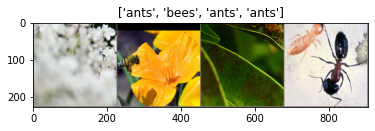

In [20]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-'*10)
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train() # set model to training mode
            else:
                model.eval() # set model to evaluation mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                #Forward
                #track history if only in train
                with torch.set_grad_enabled(phase=='train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training comlete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    #load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [22]:
# Finetuning the covnet #
# Load a pretrained model and reset final fully connected layer
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2
# Alternatively it can be generalized to nn.Linear(num_ftrs, len(class_names))
model.fc = nn.Linear(num_ftrs, 2)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = optim.SGD(model.parameters(), lr=0.001)

# StepLR decays the learning rate of each parameter group by gamma every step_size epochs
# Decay LR by a factor of 0.1 every 7 epochs
# Learning rate scheduling should be applied after optimizer's update
# e.g you should write your code this way
# for epoch in range(100):
# train(...)
# validater(...)
# scheduler.step()

step_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma=0.1) # every 7th epoch, learning rate (lr) * gamma

model = train_model(model, criterion, optimizer, step_lr_scheduler, num_epochs=25)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Epoch 0/24
----------
train Loss: 0.6380 Acc: 0.5984
val Loss: 0.4878 Acc: 0.7516
Epoch 1/24
----------
train Loss: 0.5345 Acc: 0.7541
val Loss: 0.3620 Acc: 0.8954
Epoch 2/24
----------
train Loss: 0.5186 Acc: 0.7664
val Loss: 0.3249 Acc: 0.8758
Epoch 3/24
----------
train Loss: 0.4327 Acc: 0.8033
val Loss: 0.2954 Acc: 0.9020
Epoch 4/24
----------
train Loss: 0.4181 Acc: 0.8074
val Loss: 0.2589 Acc: 0.9150
Epoch 5/24
----------
train Loss: 0.3851 Acc: 0.8115
val Loss: 0.2486 Acc: 0.9020
Epoch 6/24
----------
train Loss: 0.3724 Acc: 0.8279
val Loss: 0.2379 Acc: 0.9150
Epoch 7/24
----------
train Loss: 0.3941 Acc: 0.8115
val Loss: 0.2295 Acc: 0.9150
Epoch 8/24
----------
train Loss: 0.3582 Acc: 0.8525
val Loss: 0.2563 Acc: 0.9085
Epoch 9/24
----------
train Loss: 0.3529 Acc: 0.8525
val Loss: 0.2364 Acc: 0.9085
Epoch 10/24
----------
train Loss: 0.3317 Acc: 0.8484
val Loss: 0.2502 Acc: 0.9150
Epoch 11/24
----------
train Loss: 0.3707 Acc: 0.8279
val Loss: 0.2416 Acc: 0.9150
Epoch 12/24
--

In [24]:
## Convnet as fixed feature extractor ###
# Here we need to freeze all the network except the final layer
# We need to set requires_grad == False to freeze the parameters so that the gradient are not computed in backward()
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as opposed to before
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)  # Stochastic Gradient Descent

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6857 Acc: 0.6557
val Loss: 0.2677 Acc: 0.8889
Epoch 1/24
----------
train Loss: 0.4850 Acc: 0.7623
val Loss: 0.3239 Acc: 0.8627
Epoch 2/24
----------
train Loss: 0.4598 Acc: 0.7828
val Loss: 0.1946 Acc: 0.9216
Epoch 3/24
----------
train Loss: 0.5156 Acc: 0.7664
val Loss: 0.2121 Acc: 0.9281
Epoch 4/24
----------
train Loss: 0.4642 Acc: 0.7992
val Loss: 0.1871 Acc: 0.9477
Epoch 5/24
----------
train Loss: 0.3847 Acc: 0.8361
val Loss: 0.2144 Acc: 0.9346
Epoch 6/24
----------
train Loss: 0.3532 Acc: 0.8238
val Loss: 0.1909 Acc: 0.9412
Epoch 7/24
----------
train Loss: 0.3116 Acc: 0.8525
val Loss: 0.1941 Acc: 0.9477
Epoch 8/24
----------
train Loss: 0.3556 Acc: 0.8402
val Loss: 0.2010 Acc: 0.9346
Epoch 9/24
----------
train Loss: 0.3871 Acc: 0.8484
val Loss: 0.1758 Acc: 0.9477
Epoch 10/24
----------
train Loss: 0.3201 Acc: 0.8689
val Loss: 0.1705 Acc: 0.9477
Epoch 11/24
----------
train Loss: 0.3801 Acc: 0.8648
val Loss: 0.2071 Acc: 0.9346
Epoch 12/24
--